<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210927_DictL_%E5%8D%98%E3%83%A6%E3%83%8B%E3%83%83%E3%83%88%E5%AD%A6%E7%BF%92_%E3%83%86%E3%82%B9%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import math
import statistics
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import DictionaryLearning
from xgboost import XGBRegressor

import warnings
warnings.simplefilter('ignore')

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data',
 'notebook',
 'C0002_21_09_2021.csv',
 'C0002_23_09_2021.csv',
 'ref',
 'C0002_27_09_2021.csv',
 'C0002_27_09_2021_2.csv',
 'C0002_27_09_2021_3.csv']

In [3]:
#データの読み込み
dataframe_train = pd.read_csv(
    os.path.join(DIR, 'data', 'Train_Unit_20210903', 'dataset_train_all.csv'),
    encoding='utf-8')
dataframe_test = pd.read_csv(
    os.path.join(DIR, 'data', 'Test_Unit_20210903', 'dataset_test_all.csv'),
    encoding='utf-8')

関数群

In [4]:
def data_processed(dataframe):
  #不必要なIndex列と空白列を削除。
  df = dataframe.drop(dataframe.columns[[0, 7]], axis=1)

  #カラム名変更前後の辞書
  col_list = {'Time (s)' : 'Time',
            'Voltage Measured (V)' : 'VM',
            'Voltage Charge (V)' : 'VC',
            'Current Measured (Amps)' : 'CM', 
            'Current Charge (Amps)' : 'CC',
            'Temperature (degree C)': 'Temp', 
            'unit' : 'unit_name', 
            'charge_mode' : 'mode', 
            'Cycle_num' : 'Cycle',
            'Voltage Load (V)' : 'VL',
            'Current Load (Amps)' : 'CL'
  }
  
  df = df.rename(columns=col_list)
  
  #ユニットとサイクルでソート。
  df = df.sort_values(['unit_name', 'Cycle']).reset_index(drop=True)

  return df

In [6]:
#関数化：グループIDを付与する。
def add_group(max_value, df, interval):
  group_list = []
  for i in np.arange(1, max_value/interval):
      lower = interval*i-interval
      upper = interval*i
      tmp_df = df[ (lower < df['Time']) & (upper > df['Time'])]
      tmp_df['group_id'] = f'{lower} -- {upper}'
      group_list.append(tmp_df)
  df_add_group = pd.concat(group_list)
  return df_add_group

In [7]:
#max_value = 11000
#base_df = train_c
#interval = 50
#col = 'VM'
#mode = C

#DictLによる特徴量の抽出とデータフレーム化
def autofe_by_dictl(max_value, base_df, interval, col, mode):

  add_group_id = add_group(max_value, base_df, interval=interval)
  add_group_id = add_group_id.reset_index(drop=True)

  #サイクル、グループID毎にグループ化し、平均値をとる。
  grouped_df_mean = add_group_id.groupby(['Cycle', 'group_id']).mean().sort_values(['Cycle','Time'])

  #ピボットテーブルを作成
  pt = pd.pivot_table(grouped_df_mean, index='group_id', columns='Cycle', values=col)
  #欠測値は削除。
  pt = pt.dropna()

  #学習データの設定
  X = np.asarray(pt.values)
  X_train = X

  #辞書学習による特徴量抽出
  n_components = 10
  dict_learner = DictionaryLearning(
        n_components=n_components,
        fit_algorithm='cd',
        transform_algorithm = 'lasso_lars',
        random_state = 42,
        positive_code = False,
        positive_dict = False,
        alpha = 1
    )

  X_train_transformed = dict_learner.fit_transform(X_train)

  cols = []
  for i in np.arange(0, n_components):
    c = f'Component_{i}_{col}_{mode}'
    cols.append(c)
  
  df_dict = pd.DataFrame(dict_learner.components_.T, columns=cols)

  return df_dict

In [8]:
def make_dataset(df_charge, df_discharge):

  col_charge = df_charge.columns[1:6]

  df_dict_charge = []
  for col in col_charge:
    tmp_df_charge = autofe_by_dictl(11000, df_charge, 50, col, 'C')
    df_dict_charge.append(tmp_df_charge)

  col_discharge = list([df_discharge.columns[1], df_discharge.columns[3], df_discharge.columns[5], df_discharge.columns[-2]])

  df_dict_discharge = []
  for col in col_discharge:
    tmp_df_discharge = autofe_by_dictl(11000, df_discharge, 50, col, 'D')
    df_dict_discharge.append(tmp_df_discharge)

  df_merge_charge = pd.concat([df_dict_charge[0],df_dict_charge[1], df_dict_charge[2], df_dict_charge[3],df_dict_charge[4]],axis=1)
  df_merge_discharge = pd.concat([df_dict_discharge[0],df_dict_discharge[1], df_dict_discharge[2], df_dict_discharge[3]],axis=1)
  df_dict_merge = pd.concat([df_merge_charge, df_merge_discharge], axis=1)

  return df_dict_merge

学習データ・テストデータ作成

In [9]:
df_train_base = data_processed(dataframe_train)
df_test_base = data_processed(dataframe_test)

In [13]:
#充電と放電について、データセットを分ける(学習データ)
train_c_1 = df_train_base[(df_train_base['mode'] == 'Charge')&(df_train_base['unit_name'] == 'Train_Unit_1')]
train_c_2 = df_train_base[(df_train_base['mode'] == 'Charge')&(df_train_base['unit_name'] == 'Train_Unit_2')]
train_c_3 = df_train_base[(df_train_base['mode'] == 'Charge')&(df_train_base['unit_name'] == 'Train_Unit_3')]
train_d_1 = df_train_base[(df_train_base['mode'] == 'Discharge')&(df_train_base['unit_name'] == 'Train_Unit_1')]
train_d_2 = df_train_base[(df_train_base['mode'] == 'Discharge')&(df_train_base['unit_name'] == 'Train_Unit_2')]
train_d_3 = df_train_base[(df_train_base['mode'] == 'Discharge')&(df_train_base['unit_name'] == 'Train_Unit_3')]

In [14]:
#充電と放電について、データセットを分ける(テストデータ)
test_c_1 = df_test_base[(df_test_base['mode'] == 'Charge')&(df_test_base['unit_name'] == 'Test_Unit_1')]
test_c_2 = df_test_base[(df_test_base['mode'] == 'Charge')&(df_test_base['unit_name'] == 'Test_Unit_2')]
test_c_3 = df_test_base[(df_test_base['mode'] == 'Charge')&(df_test_base['unit_name'] == 'Test_Unit_3')]
test_d_1 = df_test_base[(df_test_base['mode'] == 'Discharge')&(df_test_base['unit_name'] == 'Test_Unit_1')]
test_d_2 = df_test_base[(df_test_base['mode'] == 'Discharge')&(df_test_base['unit_name'] == 'Test_Unit_2')]
test_d_3 = df_test_base[(df_test_base['mode'] == 'Discharge')&(df_test_base['unit_name'] == 'Test_Unit_3')]

In [15]:
df_train_dict_merge_unit_1 = make_dataset(train_c_1, train_d_1)
df_train_dict_merge_unit_2 = make_dataset(train_c_2, train_d_2)
df_train_dict_merge_unit_3 = make_dataset(train_c_3, train_d_3)

In [16]:
df_test_dict_merge_unit_1 = make_dataset(test_c_1, test_d_1)
df_test_dict_merge_unit_2 = make_dataset(test_c_2, test_d_2)
df_test_dict_merge_unit_3 = make_dataset(test_c_3, test_d_3)

In [27]:
#学習データに目的変数(RUL)を付与する。
def add_rul(dict_dataframe):
  dict_dataframe['Cycle'] = dict_dataframe.index + 1
  dict_dataframe['RUL'] = dict_dataframe.shape[0] - dict_dataframe['Cycle']
  return dict_dataframe

In [17]:
df_train_dict_merge_unit_1.shape

(124, 90)

In [35]:
df_train_unit_1 = add_rul(df_train_dict_merge_unit_1)
df_train_unit_2 = add_rul(df_train_dict_merge_unit_2)
df_train_unit_3 = add_rul(df_train_dict_merge_unit_3)

In [38]:
df_train_unit_1.head()

,Component_0_VM_C,Component_1_VM_C,Component_2_VM_C,Component_3_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_9_VM_C,Component_0_VC_C,Component_1_VC_C,Component_2_VC_C,Component_3_VC_C,Component_4_VC_C,Component_5_VC_C,Component_6_VC_C,Component_7_VC_C,Component_8_VC_C,Component_9_VC_C,Component_0_CM_C,Component_1_CM_C,Component_2_CM_C,Component_3_CM_C,Component_4_CM_C,Component_5_CM_C,Component_6_CM_C,Component_7_CM_C,Component_8_CM_C,Component_9_CM_C,Component_0_CC_C,Component_1_CC_C,Component_2_CC_C,Component_3_CC_C,Component_4_CC_C,Component_5_CC_C,Component_6_CC_C,Component_7_CC_C,Component_8_CC_C,Component_9_CC_C,...,Component_2_VM_D,Component_3_VM_D,Component_4_VM_D,Component_5_VM_D,Component_6_VM_D,Component_7_VM_D,Component_8_VM_D,Component_9_VM_D,Component_0_CM_D,Component_1_CM_D,Component_2_CM_D,Component_3_CM_D,Component_4_CM_D,Component_5_CM_D,Component_6_CM_D,Component_7_CM_D,Component_8_CM_D,Component_9_CM_D,Component_0_Temp_D,Component_1_Temp_D,Component_2_Temp_D,Component_3_Temp_D,Component_4_Temp_D,Component_5_Temp_D,Component_6_Temp_D,Component_7_Temp_D,Component_8_Temp_D,Component_9_Temp_D,Component_0_VL_D,Component_1_VL_D,Component_2_VL_D,Component_3_VL_D,Component_4_VL_D,Component_5_VL_D,Component_6_VL_D,Component_7_VL_D,Component_8_VL_D,Component_9_VL_D,Cycle,RUL
0,-0.088436,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883,-0.088848,0.084457,0.090646,-0.030568,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,-0.090142,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883,-0.090150,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883,...,-0.037228,-0.069598,-0.108302,0.061690,0.124684,0.038337,0.045401,-0.022837,0.089812,-0.061001,0.090646,-0.030568,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,-0.089134,-0.089373,0.068318,0.102890,0.014991,-0.123744,-0.068117,-0.052658,-0.140624,0.017610,-0.092151,0.096686,0.099056,-0.026482,-0.002566,-0.071721,-0.022561,0.054619,-0.104856,-0.078625,1,123
1,-0.088418,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149,-0.088924,0.085048,0.048796,0.056109,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.090149,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149,-0.090144,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149,...,-0.034308,-0.019639,0.159657,0.132447,-0.058768,0.064983,-0.030635,0.047208,0.089807,-0.061049,0.048796,0.056109,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.089485,-0.093390,0.069346,0.107514,0.071699,0.039294,0.107967,0.113073,-0.036475,0.045789,-0.091860,0.096615,0.098978,0.117668,-0.009323,0.028246,-0.055958,0.066295,0.023217,0.016425,2,122
2,-0.088457,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279,-0.089003,0.085574,0.068959,-0.050614,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,-0.090156,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279,-0.090145,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279,...,0.016093,0.054631,0.001648,0.031761,0.043435,-0.004736,-0.103293,0.005810,0.089799,-0.061101,0.068959,-0.050614,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,-0.089299,-0.094326,0.069511,0.108664,-0.255212,-0.115993,-0.080185,0.035647,0.000925,0.098425,-0.091770,0.096465,0.098958,-0.004728,-0.013884,0.013364,-0.015683,0.008074,-0.072198,0.070815,3,121
3,-0.088414,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,0.017830,0.095270,0.105180,-0.089001,0.085478,0.049091,-0.015143,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,-0.090147,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,0.017830,0.095270,0.105180,-0.090132,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,0.017830,0.095270,0.

学習～推論

In [37]:
train_X_1 = df_train_unit_1.iloc[:, :-2]
train_X_2 = df_train_unit_2.iloc[:, :-2]
train_X_3 = df_train_unit_3.iloc[:, :-2]

train_y_1 = df_train_unit_1.iloc[:,-1]
train_y_2 = df_train_unit_2.iloc[:,-1]
train_y_3 = df_train_unit_3.iloc[:,-1]

In [39]:
test_X_1 = df_test_dict_merge_unit_1
test_X_2 = df_test_dict_merge_unit_2
test_X_3 = df_test_dict_merge_unit_3

In [50]:
train_X_1
#train_y_1

,Component_0_VM_C,Component_1_VM_C,Component_2_VM_C,Component_3_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_9_VM_C,Component_0_VC_C,Component_1_VC_C,Component_2_VC_C,Component_3_VC_C,Component_4_VC_C,Component_5_VC_C,Component_6_VC_C,Component_7_VC_C,Component_8_VC_C,Component_9_VC_C,Component_0_CM_C,Component_1_CM_C,Component_2_CM_C,Component_3_CM_C,Component_4_CM_C,Component_5_CM_C,Component_6_CM_C,Component_7_CM_C,Component_8_CM_C,Component_9_CM_C,Component_0_CC_C,Component_1_CC_C,Component_2_CC_C,Component_3_CC_C,Component_4_CC_C,Component_5_CC_C,Component_6_CC_C,Component_7_CC_C,Component_8_CC_C,Component_9_CC_C,...,Component_0_VM_D,Component_1_VM_D,Component_2_VM_D,Component_3_VM_D,Component_4_VM_D,Component_5_VM_D,Component_6_VM_D,Component_7_VM_D,Component_8_VM_D,Component_9_VM_D,Component_0_CM_D,Component_1_CM_D,Component_2_CM_D,Component_3_CM_D,Component_4_CM_D,Component_5_CM_D,Component_6_CM_D,Component_7_CM_D,Component_8_CM_D,Component_9_CM_D,Component_0_Temp_D,Component_1_Temp_D,Component_2_Temp_D,Component_3_Temp_D,Component_4_Temp_D,Component_5_Temp_D,Component_6_Temp_D,Component_7_Temp_D,Component_8_Temp_D,Component_9_Temp_D,Component_0_VL_D,Component_1_VL_D,Component_2_VL_D,Component_3_VL_D,Component_4_VL_D,Component_5_VL_D,Component_6_VL_D,Component_7_VL_D,Component_8_VL_D,Component_9_VL_D
0,-0.088436,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883,-0.088848,0.084457,0.090646,-0.030568,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,-0.090142,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883,-0.090150,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883,...,-0.090425,0.094061,-0.037228,-0.069598,-0.108302,0.061690,0.124684,0.038337,0.045401,-0.022837,0.089812,-0.061001,0.090646,-0.030568,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,-0.089134,-0.089373,0.068318,0.102890,0.014991,-0.123744,-0.068117,-0.052658,-0.140624,0.017610,-0.092151,0.096686,0.099056,-0.026482,-0.002566,-0.071721,-0.022561,0.054619,-0.104856,-0.078625
1,-0.088418,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149,-0.088924,0.085048,0.048796,0.056109,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.090149,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149,-0.090144,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149,...,-0.090544,0.094257,-0.034308,-0.019639,0.159657,0.132447,-0.058768,0.064983,-0.030635,0.047208,0.089807,-0.061049,0.048796,0.056109,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.089485,-0.093390,0.069346,0.107514,0.071699,0.039294,0.107967,0.113073,-0.036475,0.045789,-0.091860,0.096615,0.098978,0.117668,-0.009323,0.028246,-0.055958,0.066295,0.023217,0.016425
2,-0.088457,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279,-0.089003,0.085574,0.068959,-0.050614,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,-0.090156,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279,-0.090145,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279,...,-0.090581,0.094288,0.016093,0.054631,0.001648,0.031761,0.043435,-0.004736,-0.103293,0.005810,0.089799,-0.061101,0.068959,-0.050614,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,-0.089299,-0.094326,0.069511,0.108664,-0.255212,-0.115993,-0.080185,0.035647,0.000925,0.098425,-0.091770,0.096465,0.098958,-0.004728,-0.013884,0.013364,-0.015683,0.008074,-0.072198,0.070815
3,-0.088414,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,0.017830,0.095270,0.105180,-0.089001,0.085478,0.049091,-0.015143,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,-0.090147,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,0.017830,0.095270,0.105180,-0.090132,0.067228,0.039

In [42]:
print('-'*5)
print('カラム数の確認')
print(f'学習D_1のカラム数：{train_X_1.shape[1]}',f'テストD_1のカラム数：{test_X_1.shape[1]}')
print(f'学習D_2のカラム数：{train_X_2.shape[1]}',f'テストD_1のカラム数：{test_X_2.shape[1]}')
print(f'学習D_3のカラム数：{train_X_3.shape[1]}',f'テストD_1のカラム数：{test_X_3.shape[1]}')

print('-'*5)
print('レコード数の確認')
print(f'学習D_1のレコード数：{train_X_1.shape[0]}',f'テストD_1のレコード数：{test_X_1.shape[0]}')
print(f'学習D_2のレコード数：{train_X_2.shape[0]}',f'テストD_1のレコード数：{test_X_2.shape[0]}')
print(f'学習D_3のレコード数：{train_X_3.shape[0]}',f'テストD_1のレコード数：{test_X_3.shape[0]}')

-----
カラム数の確認
学習D_1のカラム数：90 テストD_1のカラム数：90
学習D_2のカラム数：90 テストD_1のカラム数：90
学習D_3のカラム数：90 テストD_1のカラム数：90
-----
レコード数の確認
学習D_1のレコード数：124 テストD_1のレコード数：70
学習D_2のレコード数：40 テストD_1のレコード数：12
学習D_3のレコード数：97 テストD_1のレコード数：55


In [44]:
#モデルの作成
model_1 = XGBRegressor(n_estimators=20, random_state=71)
model_2 = XGBRegressor(n_estimators=20, random_state=71)
model_3 = XGBRegressor(n_estimators=20, random_state=71)

model_1.fit(train_X_1,train_y_1)
model_2.fit(train_X_2,train_y_2)
model_3.fit(train_X_3,train_y_3)

[14:16:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=71,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [45]:
#テストデータの予測値を出力
pred_1 = model_1.predict(test_X_1)
pred_2 = model_2.predict(test_X_2)
pred_3 = model_3.predict(test_X_3)

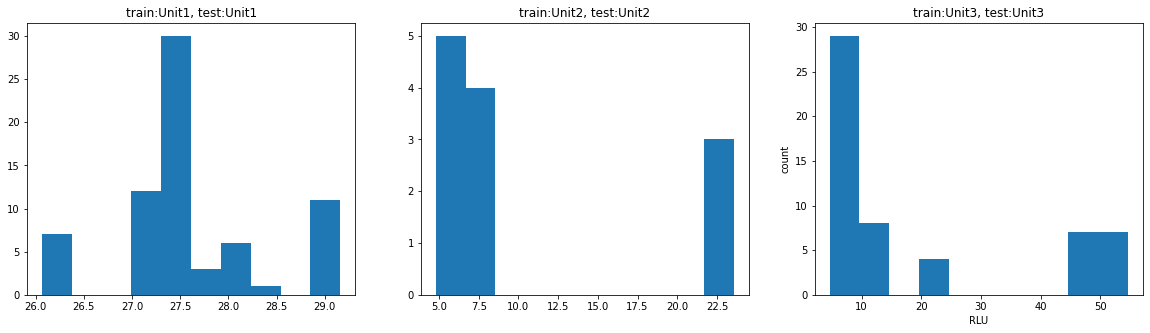

In [51]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.hist(pred_1, bins=10)
ax1.set_title('train:Unit1, test:Unit1')

ax2.hist(pred_2, bins=10)
ax2.set_title('train:Unit2, test:Unit2')

ax3.hist(pred_3, bins=10)
ax3.set_title('train:Unit3, test:Unit3')

plt.xlabel('RLU')
plt.ylabel('count')
plt.show()


In [55]:
#ヒストグラムの最頻値をRULと定義
RUL_unit_1 = round(statistics.mean(pred_1))
RUL_unit_2 = round(statistics.mean(pred_2))
RUL_unit_3 = round(statistics.mean(pred_3))

print('RUL_test_unit_1：',RUL_unit_1)
print('RUL_test_unit_2：',RUL_unit_2)
print('RUL_test_unit_3：',RUL_unit_3)

RUL_test_unit_1： 28
RUL_test_unit_2： 11
RUL_test_unit_3： 20


全組み合わせを試してみる

In [56]:
#テストデータの予測値を出力
pred_train1_test1 = model_1.predict(test_X_1)
pred_train1_test2 = model_1.predict(test_X_2)
pred_train1_test3 = model_1.predict(test_X_3)

pred_train2_test1 = model_2.predict(test_X_1)
pred_train2_test2 = model_2.predict(test_X_2)
pred_train2_test3 = model_2.predict(test_X_3)

pred_train3_test1 = model_3.predict(test_X_1)
pred_train3_test2 = model_3.predict(test_X_2)
pred_train3_test3 = model_3.predict(test_X_3)

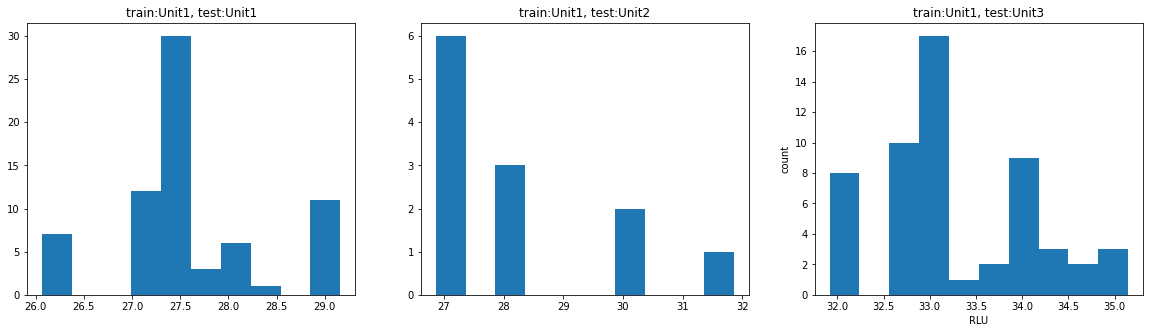

In [58]:
#train1
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.hist(pred_train1_test1, bins=10)
ax1.set_title('train:Unit1, test:Unit1')

ax2.hist(pred_train1_test2, bins=10)
ax2.set_title('train:Unit1, test:Unit2')

ax3.hist(pred_train1_test3, bins=10)
ax3.set_title('train:Unit1, test:Unit3')

plt.xlabel('RLU')
plt.ylabel('count')
plt.show()


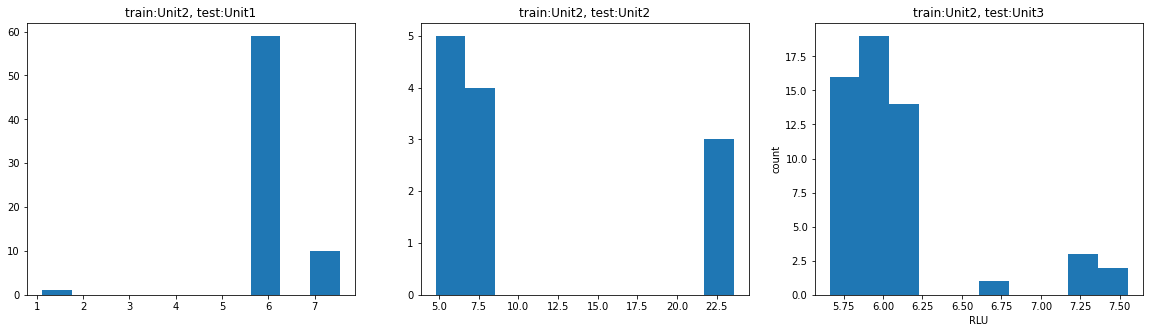

In [59]:
#train2
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.hist(pred_train2_test1, bins=10)
ax1.set_title('train:Unit2, test:Unit1')

ax2.hist(pred_train2_test2, bins=10)
ax2.set_title('train:Unit2, test:Unit2')

ax3.hist(pred_train2_test3, bins=10)
ax3.set_title('train:Unit2, test:Unit3')

plt.xlabel('RLU')
plt.ylabel('count')
plt.show()


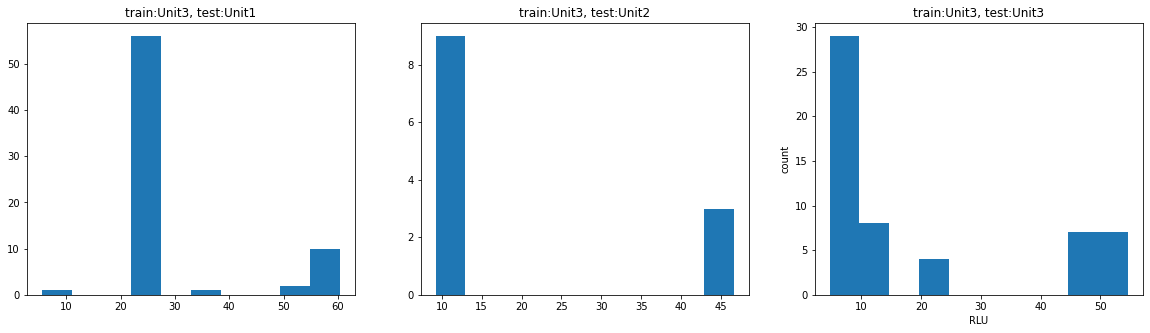

In [60]:
#train3
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.hist(pred_train3_test1, bins=10)
ax1.set_title('train:Unit3, test:Unit1')

ax2.hist(pred_train3_test2, bins=10)
ax2.set_title('train:Unit3, test:Unit2')

ax3.hist(pred_train3_test3, bins=10)
ax3.set_title('train:Unit3, test:Unit3')

plt.xlabel('RLU')
plt.ylabel('count')
plt.show()
